# 0. Load packages and imports

In [1]:


## basic functionality
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt


## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Individual portion

Use the same `sentencing_cleaned` data for this portion. 

In the group portion, you investigated one form of disparity: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate how variation between different judges in the severity of the sentence relates to disparities. 

In [2]:
sentencing_cleaned=pd.read_csv("../../data/sentencing_cleaned.csv")



/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10,11,16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 3.1 Filter to incarceration and construct a sentence length variable (6 points)

Defendants can be sentenced to different lengths for probation, but for simplicity:

- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as above)
- Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
- Filter to Black or White defendants

Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`). To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column

Print the summary of that sentence length column using the .describe() command

In [17]:

#Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as above)

incar = sentencing_cleaned[sentencing_cleaned['COMMITMENT_TYPE'].str.fullmatch("Illinois Department of Corrections", na = False)].copy()


#Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
non_num = incar['COMMITMENT_UNIT'].isin(['Term', 'Pounds', 'Dollars'])
incar = incar[~non_num].copy()


# Filter to Black or White defendants
incar = incar[(incar['is_black_derived']== True)| (incar['is_white_derived']== True)].copy()


In [18]:
#Then, follow the instructions in the codebook (combining COMMITMENT_TERM with COMMITMENT_UNIT) 
#to create a standard sentence length in days column (senlength_derived)
##Natural life = difference between the age of 100 and the defendant's age at incident
##cleaned; if missing, code to age 20); note that this is a simplification since age at 
##incident != age at sentencing

incar['COMMITMENT_TERM'] = incar['COMMITMENT_TERM'].astype('string').str.replace('\.0', '').astype(float)

incar['age_derived'].fillna(value = 20, inplace = True)

incar["age_new"]=incar['age_derived']*365


incar['commitment_unit_clean'] = incar['COMMITMENT_UNIT'].map({"Year(s)":365, "Weeks":7,"Hours":1/24 , 
                                        "Months":30.5 , "Days":1 }).fillna(incar['COMMITMENT_UNIT'])

incar['commitment_unit_clean']=np.where(incar.COMMITMENT_UNIT=="Natural Life", 
                                      36500-incar['age_new'],incar['commitment_unit_clean'])


incar["senlength_derived"]= incar["commitment_unit_clean"] * incar["COMMITMENT_TERM"]
                                                            


<ipython-input-18-bfe30211d5af>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  incar['COMMITMENT_TERM'] = incar['COMMITMENT_TERM'].astype('string').str.replace('\.0', '').astype(float)


In [5]:

#Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): COMMITMENT_TERM, COMMITMENT_UNIT, 
#age_derived and your new standardized sentence length column

result = incar.groupby('COMMITMENT_UNIT').apply(lambda x: x.sample(1)).reset_index(drop=True)
result_final = result[["COMMITMENT_UNIT","COMMITMENT_TERM", "age_derived", "senlength_derived"]]
result_final
                                               
                                                        


,COMMITMENT_UNIT,COMMITMENT_TERM,age_derived,senlength_derived
0,Days,90.0,40.0,90.000000
1,Hours,1.0,22.0,0.041667
2,Months,30.0,55.0,915.000000
3,Natural Life,1.0,37.0,22995.000000
4,Weeks,2.0,23.0,14.000000
5,Year(s),3.0,50.0,1095.000000


In [6]:

#Print the summary of that sentence length column using the .describe() command
incar["senlength_derived"].describe()


count     58289.0
unique      235.0
top         365.0
freq      14456.0
Name: senlength_derived, dtype: float64

In [14]:
## rj comment
## great job! but small issue if you look at the distribution
## the max sentence is 2810500 which seems high
incar['senlength_num'] = incar.senlength_derived.astype(float)
incar.senlength_num.describe().apply(lambda x: format(x, 'f'))

## look at the max one
max_sent = incar[incar.senlength_num == incar.senlength_num.max()]
max_sent[['senlength_derived', 'senlength_num', 'age_derived', 'age_new', 'COMMITMENT_UNIT', 'COMMITMENT_TERM']]

## see that there's an issue with this line
## it's fine to multiply for the non natural length ones but 
## for the natural life ones, the commitment_term is just the natural life
## incar["senlength_derived"]= incar["commitment_unit_clean"] * incar["COMMITMENT_TERM"]

## so in the example above, the example should be 
## 100 * 365 = 36500 - 8395 days old = 28105 days
## not then multiplied by 100 again since commitment_term
## isn't meaningful for that

count      58289.000000
mean        1533.461978
std        19653.011841
min            0.000000
25%          366.000000
50%          915.000000
75%         1460.000000
max      2810500.000000
Name: senlength_num, dtype: object

,senlength_derived,senlength_num,age_derived,age_new,COMMITMENT_UNIT,COMMITMENT_TERM
480,2810500.0,2810500.0,23.0,8395.0,Natural Life,100.0


## 3.2 Examine disparities in length within the same judge and offense category: no adjustment (2 points)

- Filter to narcotics offenses 

- For each judge with at least 20 Black and at least 20 white defendants, plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)

- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?

<ipython-input-15-d58177cf93ad>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  organized = incar.groupby(["judgeid_derived"])["is_black_derived", "is_white_derived"].sum().reset_index()


Text(0.5, 1.0, 'Comparison of Median Sentence Length By Race Determined By Selected Judges')

Text(0.5, 0, 'Judges')

Text(0, 0.5, 'Median Sentence Length(Days)')

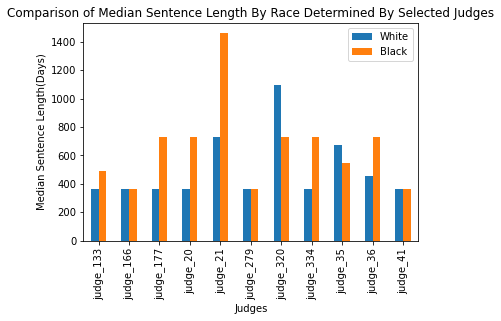

In [15]:
# Filter to narcotics offenses 

incar = incar[incar['simplified_offense_derived']=="Narcotics"]

organized = incar.groupby(["judgeid_derived"])["is_black_derived", "is_white_derived"].sum().reset_index()

organized = organized[(organized['is_black_derived']>=20)&(organized['is_white_derived']>=20)]

# print(organized)

judge_list = ["judge_133","judge_166","judge_177","judge_20","judge_21","judge_279","judge_320"
             ,"judge_334","judge_35","judge_36","judge_41"]

incar = incar[incar['judgeid_derived'].isin(judge_list)]

incar['senlength_derived'] = incar['senlength_derived'].astype(float)

organized2= incar.groupby(["judgeid_derived","is_black_derived"]).agg({'senlength_derived': 'median'}).reset_index()
final=organized2.pivot(index="judgeid_derived", columns="is_black_derived", values="senlength_derived").plot(kind="bar")
final.legend(["White", "Black"])
plt.title('Comparison of Median Sentence Length By Race Determined By Selected Judges')
plt.xlabel('Judges')
plt.ylabel('Median Sentence Length(Days)')
plt.show()




In [129]:
# Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly 
# assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?

## From the plot "Comparison of Median Sentence Length By Race Determined By Selected Judges," we can notice quite
## clearly that Black has disproportionately higher median sentence legths as among the eleven
## judges, 5 judges gave a higher sentence length for Black with 3 judges giving equal sentence length. This contrast 
## and interesting result from the plot can possible suggest the bias and racism underlined and influenced the judical
## discretion that then widen the racial disparities and challenge the idea of "fairness" in law. However, it is 
## important to note that although median is statistically more representative, the sentence length can still be skewed
## to a extent of outliers who commit more severe crime and have a long sentence length. 


In [16]:
## rj comment-
## good job!
## no deduction this time but in future, remember
## not to hard-code the judge vector (manually enter)

## instead, could use code like this using isin
## to avoid errors from writing out the judges in a vector
subset_judges = incar[incar.judgeid_derived.isin(organized.judgeid_derived)].copy()

,judgeid_derived,is_black_derived,is_white_derived
14,judge_133,83,24
30,judge_166,36,49
35,judge_177,37,23
44,judge_20,100,21
48,judge_21,22,31


## 3.3 Examine disparities in length within the same judge and offense category: constructing matched pairs (6 points)

Focus on `judgeid_derived` = `judge_21` and the same narcotics offenses. For each defendant, you want to construct "matched groups" of defendants who:

- Are the same exact age
- Are the same gender
- Differ in race from the focal defendant

Use code to find any/all matched defendants for each focal defendant. Print a table that compares the sentence length for focal compared to others and comment on what other things you'd like to match on if we had a larger dataset
    

In [19]:
judges_example = incar.loc[incar['judgeid_derived'] == "judge_21"]

def proximate_defendent(data,i):
    defendant_lookfor = data.iloc[i]
    other_defendants = data.loc[data['CASE_ID'] != defendant_lookfor['CASE_ID']]
    same_stuff = other_defendants.loc[other_defendants["age_derived"] == defendant_lookfor["age_derived"]]
    same_stuff = same_stuff.loc[same_stuff["is_male_derived"] == defendant_lookfor["is_male_derived"]]
    same_stuff = same_stuff.loc[same_stuff["is_white_derived"] != defendant_lookfor["is_white_derived"]]
    table = pd.DataFrame()       
    table["match_CASE_ID"] = same_stuff.CASE_ID
    table["match_is_male"] = same_stuff.is_male_derived
    table["match_is_white"] = same_stuff.is_white_derived
    table["match_age"] = same_stuff.age_derived
    table["match_senlength"] = same_stuff.senlength_derived
    table["focal_CASE_ID"] = defendant_lookfor.CASE_ID
    table["focal_is_male"] = defendant_lookfor.is_male_derived
    table["focal_is_white"] = defendant_lookfor.is_white_derived
    table["focal_age"] = defendant_lookfor.age_derived
    table["focal_senlength"] = defendant_lookfor.senlength_derived

    return(table)

original = pd.DataFrame()


for i in range(0, judges_example.shape[0]):
    if proximate_defendent(judges_example, i).shape[0] > 0:
        individuals = proximate_defendent(judges_example, i)
        original = pd.concat([original,individuals])

original.sample(n=20)  




,match_CASE_ID,match_is_male,match_is_white,match_age,match_senlength,focal_CASE_ID,focal_is_male,focal_is_white,focal_age,focal_senlength
79284,414174524710,True,True,37.0,730.0,408667474516,True,False,37.0,1460.0
64464,408667474516,True,False,37.0,1460.0,414174524710,True,True,37.0,730.0
63656,408367450421,True,True,21.0,1095.0,408982330932,True,False,21.0,1460.0
50084,403228858598,True,False,33.0,1460.0,394810267680,True,True,33.0,365.0
62766,408014999209,True,False,19.0,2190.0,401180823345,True,True,19.0,1095.0
58381,406322205406,True,False,21.0,1460.0,407493077705,True,True,21.0,365.0
42308,400250205289,True,False,19.0,1095.0,399791137585,True,True,19.0,2555.0
32302,396456361697,True,True,32.0,2190.0,407703373595,True,False,32.0,1460.0
58381,406322205406,True,False,21.0,1460.0,408367450421,True,True,21.0,1095.0
64674,408735908793,True,False,26.0,365.0,416149279482,True,True,26.0,1095.0


In [132]:
# Comment on what other things you'd like to match on if we had a larger dataset
## If we had a larger dataset, I would like to match the education level and income of each focal and the matches.
## I think it would be interesting to analyze how education and income level can correlate with the sentence length.


In [ ]:
## rj comment - great job! good use of function

# Grade

See rubric for specific deductions

- 3.1: 5.5/6 (small deduction for error in multiplying the two cols not only for the other sentences but also for natural life)
- 3.2: 2/2 
- 3.3: 6/6

Raw score: 13.5

Scaled score: 15.42857143

# 4. Optional challenge: looking at judge characteristics

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

 